### `simulation.ipynb`
----------------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import langevin.langevin as lg
import langevin.files as fs
import importlib
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

sim = lg.Langevin3D()

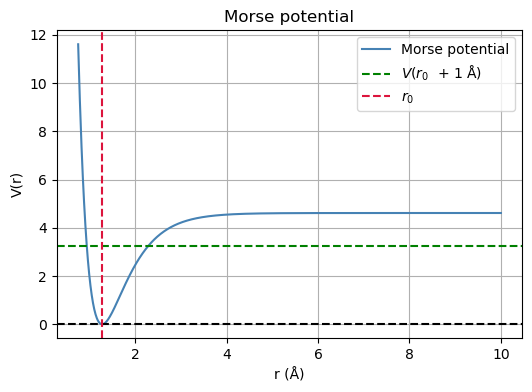

In [2]:
rv = np.linspace(0.75, 10, 1000)
pv = sim.potential_morse(rv)
offset = 1

plt.figure(figsize=(6, 4))
plt.plot(rv, pv, label='Morse potential', color='steelblue')
plt.grid()
plt.axhline(0, color='black', lw=1.5, ls='--')
plt.axhline(sim.potential_morse(sim.r_0+offset), color='green', lw=1.5, ls='--', label=r'$V(r_0$ ' f' + {offset} Å)')
plt.axvline(sim.r_0, color='crimson', lw=1.5, ls='--', label=r'$r_0$')
plt.xlabel(r"r (Å)")
plt.ylabel("V(r)")
plt.title("Morse potential")
plt.legend(loc='upper right')

In [10]:
importlib.reload(lg)
T = 300  # K
dt = 2e-16  # s
gamma = 5e11  # 1/s
potential_type = 'morse'
seed = 4
mode = 'langevin'
filename = fs.get_simulations_dir() / f'mode_{mode}_pot_{potential_type}_gamma_{int(gamma/1e9)}e9_T{T}_seed_{seed}_dt{dt*1e16}e-16.npz'

In [11]:
importlib.reload(lg)
if not filename.with_suffix('.npz').exists():
    sim = lg.Langevin3D(seed=seed, T=T, dt=dt, potential=potential_type, gamma=gamma)
    data, run_opt = sim.run(
        n_steps=40000, r_init=sim.r_0, mode='langevin', do_byproducts=True, filename=filename
        )
else:
    sim, data = lg.Langevin3D.load_from_file(filename)

Text(0, 0.5, 'Molecular bond length')

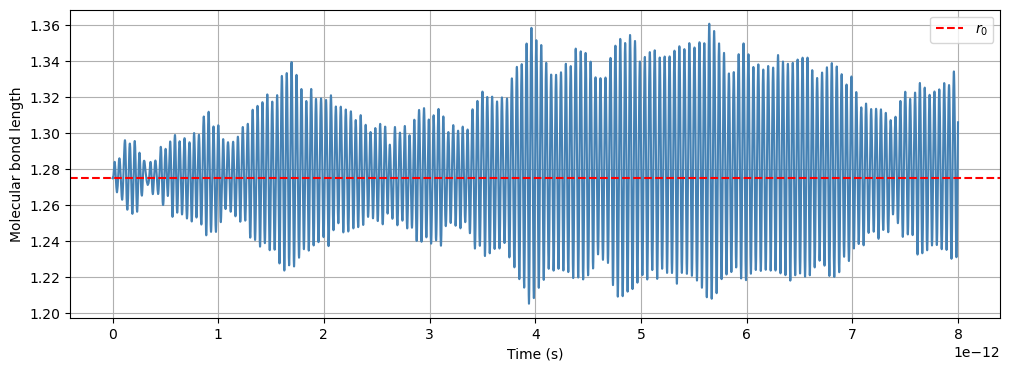

In [12]:
plt.figure(figsize=(12, 4))
plt.plot(data['time'], np.sqrt(np.sum((data['r_H']-data['r_Cl'])**2, axis=1)), color='steelblue')
plt.axhline(sim.r_0, ls='--', color='red', label=r'$r_0$')
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Time (s)')
plt.ylabel('Molecular bond length')

(0.0, 3.9998999999999995e-12)

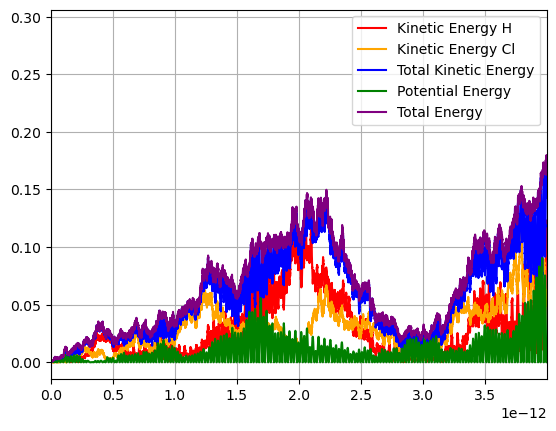

In [13]:
## energy plot
time = data['time']
kinetic_e_H = data['kinetic_energy_H']
kinetic_e_Cl = data['kinetic_energy_Cl']
potential_e = data['potential_energy']

plt.plot(time, kinetic_e_H, label='Kinetic Energy H', color='red')
plt.plot(time, kinetic_e_Cl, label='Kinetic Energy Cl', color='orange')
plt.plot(time, kinetic_e_H + kinetic_e_Cl, label='Total Kinetic Energy', color='blue')
plt.plot(time, potential_e, label='Potential Energy', color='green')
plt.plot(time, kinetic_e_H + kinetic_e_Cl + potential_e, label='Total Energy', color='purple')
plt.grid()
plt.legend(loc='upper right')
plt.xlim(0, 0.5 * time[-1])
#plt.plot(time, potential_e, label='Potential Energy', color='green')

Text(0.5, 0.92, '3D Trajectory of Cl and H Atoms')

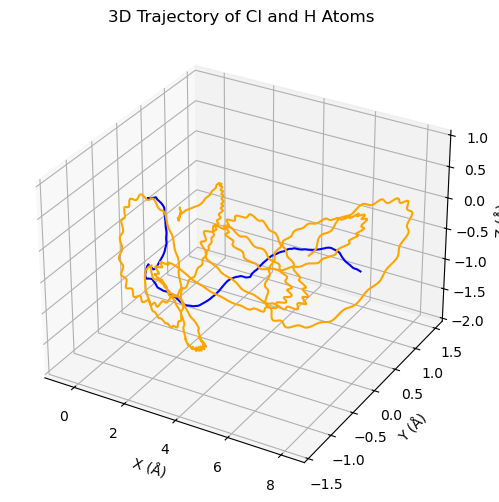

In [14]:
## 3D position of r_Cl, r_H over time
r_cl = data['r_Cl']
r_h = data['r_H']
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(r_cl[:, 0], r_cl[:, 1], r_cl[:, 2], color='blue', label='Cl')
ax.plot(r_h[:, 0], r_h[:, 1], r_h[:, 2], color='orange', label='H')
ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_zlabel('Z (Å)')
ax.set_title('3D Trajectory of Cl and H Atoms')

Number of frames: 1000


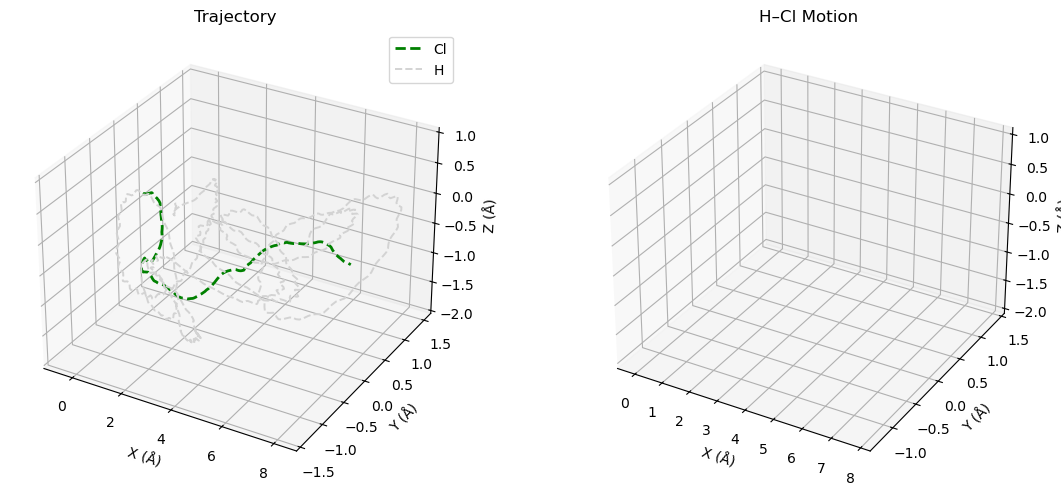

In [15]:
r_Cl = data['r_Cl'][1::40]
r_H = data['r_H'][1::40]

N = len(r_Cl)
print(f"Number of frames: {N}")

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(r_Cl[:,0], r_Cl[:,1], r_Cl[:,2], label='Cl', color='green', linestyle='--', linewidth=2)
ax1.plot(r_H[:,0],  r_H[:,1],  r_H[:,2], label='H', color='lightgray', linestyle='--', linewidth=1.4)
ax1.set_title('Trajectory')
ax1.set_xlabel('X (Å)')
ax1.set_ylabel('Y (Å)')
ax1.set_zlabel('Z (Å)')
ax1.legend()

H_marker = ax1.scatter([], [], [], s=60, c='lightgray', marker='o', label='H (current)')
Cl_marker = ax1.scatter([], [], [], s=100, c='green', marker='o', label='Cl (current)')

ax2 = fig.add_subplot(122, projection='3d')
axis_offset = 0.1
ax2.set_title('H–Cl Motion')
ax2.set_xlim(
    [
        min(np.min(r_H[:,0]), np.min(r_Cl[:,0]))-axis_offset, 
        max(np.max(r_H[:,0]), np.max(r_Cl[:,0]))+axis_offset
    ]
)
ax2.set_ylim(
    [
        min(np.min(r_H[:,1]), np.min(r_Cl[:,1]))-axis_offset, 
        max(np.max(r_H[:,1]), np.max(r_Cl[:,1]))+axis_offset
    ]
)
ax2.set_zlim(
    [
        min(np.min(r_H[:,2]), np.min(r_Cl[:,2]))-axis_offset, 
        max(np.max(r_H[:,2]), np.max(r_Cl[:,2]))+axis_offset
    ]
)
ax2.set_xlabel('X (Å)')
ax2.set_ylabel('Y (Å)')
ax2.set_zlabel('Z (Å)')

H_point = ax2.scatter([], [], [], s=200, c='lightgray')
Cl_point = ax2.scatter([], [], [], s=300, c='green')
bond_line, = ax2.plot([], [], [], color='gray', linewidth=3)

def update(frame):
    H = r_H[frame]
    Cl = r_Cl[frame]

    H_point._offsets3d = ([H[0]], [H[1]], [H[2]])
    Cl_point._offsets3d = ([Cl[0]], [Cl[1]], [Cl[2]])

    bond_line.set_data([H[0], Cl[0]], [H[1], Cl[1]])
    bond_line.set_3d_properties([H[2], Cl[2]])

    H_marker._offsets3d = ([H[0]], [H[1]], [H[2]])
    Cl_marker._offsets3d = ([Cl[0]], [Cl[1]], [Cl[2]])

    return H_point, Cl_point, bond_line, H_marker, Cl_marker

ani = FuncAnimation(fig, update, frames=N, interval=40, blit=False)

plt.tight_layout()
plt.show()

In [21]:
video = fs.get_media_dir() / filename.with_suffix('.gif')
if not video.parent.exists():
    video.parent.mkdir(parents=True, exist_ok=True)
if not video.exists():
    ani.save(video, fps=20, dpi=150)

MovieWriter ffmpeg unavailable; using Pillow instead.


: 